In [25]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sympy import symbols, integrate, oo, cos
from scipy.integrate import quad
import scipy.special as sc

In [41]:
# 單位 wavelength & velocity_g & x-vt


x_width = 100
o_width = 100
t1 = 10**(-9) # 1ns
t2 = 5*(10**(-9)) # 1ns
velocity_g = 3*10**8 # m/s
wavelength = 0.06 # m
wavelength_a = 0.1*wavelength #
wavelength_b = 1.1*wavelength #
x = np.linspace(wavelength_a, wavelength_b, x_width)
Omega = 2*math.pi*5*(10**9) # GHz
Omega_a = 0.95*Omega #
Omega_b = 1.05*Omega #
omega_s = np.linspace(Omega_a, Omega_b, o_width)                    #photon frequency
Gamma = 2*math.pi*0.01*(10**9)  # GHz
tilde_Omega = Omega - 1j*Gamma/2

In [27]:
# 初始化一个用于存储结果的二维数组
Transmission_o_x_t1 = np.array([[0+0j]*len(x)]*o_width)
Transmission_o_x_t2 = np.array([[0+0j]*len(x)]*o_width)
T1 = np.array([[0+0j]*len(x)]*o_width)
T2 = np.array([[0.0+0.0j]*len(x)]*o_width)
T3 = np.array([[0+0j]*len(x)]*o_width)

in paper's reference materials, exponential integral is defined as  
$ E_1(z) = \int_{1}^{\infty}$$\frac{e^{-zt}}{t}$$dt$&emsp;&emsp;$Real(z)>0$  
but in scipy.special.exp1, is defined as  
$ E_1(z) = \int_{z}^{\infty}$$\frac{e^{-t}}{t}$$dt$&emsp;&emsp;$z\ne0$  


In [28]:
# defined E1 function as paper
def z_real(za,zb,t):
    return math.e**(-za*t)/t*np.cos(zb*t)
def z_imag(za,zb,t):
    return math.e**(-za*t)/t*np.sin(zb*t)

def E1(za,zb):
    ans_real, _ = quad(z_real, 1, np.inf, args=(za,zb))
    ans_imag, _ = quad(z_imag, 1, np.inf, args=(za,zb))
    ans = ans_real - 1j*ans_imag
    return ans

$ 
T(\omega_s,x,t)=T(\omega_s)e^{i\frac{\omega_s}{v_g}(x-v_gt)}$  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
$+\frac {iR(\omega_s)}{2\pi } e^ {i\frac {\Omega}{v_g}(x-v_gt)} e^ {\frac {\Gamma/2}{v_g}(x-v_gt)} [E_1(i\frac {x}{v_g}\tilde \Omega))+2\pi i - E_1(-i \frac {|x-v_gt|}{v_g}\tilde\Omega)]$  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
$+\frac{R(\omega_s)}{2\pi}$ $e^{i\frac {\omega_s}{v_g}(x-v_gt)}[ici(\omega_{s}\frac{x}{v_g})+si(\omega_s\frac{x}{v_g})-ici(\omega_s\frac{|x-v_ gt|}{v_g})+si(\omega_s\frac{|x-v_gt|}{v_g})]$  
$Eq(36)$  
&emsp; &emsp; &emsp; &emsp; $x>0$ &emsp; $x-v_gt<0$

In [57]:
# Situation 1
# Using the E1 function in sc (scipy.special.exp1) to calculate, 
# The graph of the function is correct, but the values are different

# t1
for i in range(x_width):
    for k in range(o_width):
        Transmission_omega_s = (omega_s[k]-Omega)/(omega_s[k]-Omega+1j*Gamma/2)
        Reflection_omega_s = -1j*Gamma/2/(omega_s[k]-Omega+1j*Gamma/2)
        EX = x[i]-velocity_g*t1
        E1a = 1j*x[i]/velocity_g*tilde_Omega
        E1b = -1j*abs(EX)/velocity_g*tilde_Omega  
        si_a = sc.sici(omega_s[k]*x[i]/velocity_g)[0] - math.pi/2
        ci_a = sc.sici(omega_s[k]*x[i]/velocity_g)[1]
        si_b = sc.sici(omega_s[k]*abs(x[i]-velocity_g*t1)/velocity_g)[0] - math.pi/2
        ci_b = sc.sici(omega_s[k]*abs(x[i]-velocity_g*t1)/velocity_g)[1]
        # Transmission_o_x_t1 
        T1[i][k] = Transmission_omega_s*math.e**(1j*omega_s[k]/velocity_g*EX)
        T2[i][k] = 1j*Reflection_omega_s/(2*math.pi)*math.e**(1j*Omega/velocity_g*EX)*\
                   math.e**(Gamma/2/velocity_g*EX)*((sc.exp1(complex(np.real(E1a), np.imag(E1a))))\
                   + 2*math.pi*1j - (sc.exp1(complex(np.real(E1b), np.imag(E1b)))))
        T3[i][k] = Reflection_omega_s/2/math.pi*math.e**(1j*omega_s[k]/velocity_g*EX)*\
                   (1j*ci_a+si_a-1j*ci_b+si_b)          
        Transmission_o_x_t1[i][k] = T1[i][k] + T2[i][k] + T3[i][k] 

        if x[i] <= 0 :
            print('x<=0')
            print('x=',x[i])
            print('i=',i,'k=',k)
            break
        if EX >= 0 :
            print('x-velocity_g*t >= 0')
            break
        

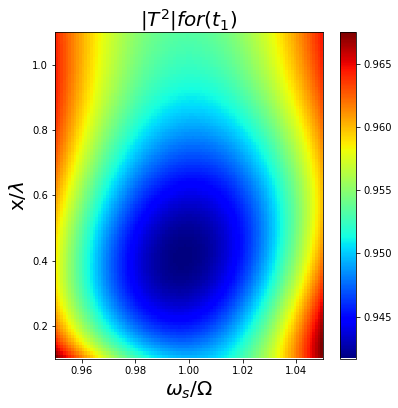

In [47]:
# 创建二维色图t
plt.figure(figsize=(6,6))
plt.imshow(abs(Transmission_o_x_t1)**2,cmap='jet', origin='lower', extent=[Omega_a/Omega, Omega_b/Omega, wavelength_a/wavelength, wavelength_b/wavelength], aspect='auto')
plt.colorbar()
plt.title('$|T^2|for(t_1)$',fontsize=20)
plt.xlabel('$\omega_s/\Omega$',fontsize=20)
plt.ylabel('x/$\lambda$',fontsize=20)
plt.show()

In [38]:
# t1

# Situation 2
# Using the custom function E1 to calculate, 
# it was found that the real part of the second E1 function value is less than zero, 
# which does not satisfy the limitations of the paper's reference materials.


for i in range(x_width):
    for k in range(o_width):
        Transmission_omega_s = (omega_s[k]-Omega)/(omega_s[k]-Omega+1j*Gamma/2)
        Reflection_omega_s = -1j*Gamma/2/(omega_s[k]-Omega+1j*Gamma/2)
        EX = x[i]-velocity_g*t1
        E1a = 1j*x[i]/velocity_g*tilde_Omega
        E1b = -1j*abs(EX)/velocity_g*tilde_Omega  # the real part of E1b is less than zero
        if np.real(E1a) <= 0 :
            print('real.E1a <=0')
            print('E1a=',E1a)
            print('i=',i)
            break
        if np.real(E1b) <= 0 :
            print('real.E1b <=0')
            print('E1b=',E1b)
            print('i=',i)
        si_a = sc.sici(omega_s[k]*x[i]/velocity_g)[0] - math.pi/2
        ci_a = sc.sici(omega_s[k]*x[i]/velocity_g)[1]
        si_b = sc.sici(omega_s[k]*abs(x[i]-velocity_g*t1)/velocity_g)[0] - math.pi/2
        ci_b = sc.sici(omega_s[k]*abs(x[i]-velocity_g*t1)/velocity_g)[1]
        # Transmission_o_x_t1 
        T1[i][k] = Transmission_omega_s*math.e**(1j*omega_s[k]/velocity_g*EX)
        T2[i][k] = 1j*Reflection_omega_s/(2*math.pi)*math.e**(1j*Omega/velocity_g*EX)*\
                   math.e**(Gamma/2/velocity_g*EX)*(E1(np.real(E1a),np.imag(E1a))\
                   + 2*math.pi*1j - E1(np.real(E1b),np.imag(E1b)))
        T3[i][k] = Reflection_omega_s/2/math.pi*math.e**(1j*omega_s[k]/velocity_g*EX)*(1j*ci_a+si_a-1j*ci_b+si_b)          
        Transmission_o_x_t1[i][k] = T1[i][k] + T2[i][k] + T3[i][k] 

        if x[i] <= 0 :
            print('x<=0')
            print('x=',x[i])
            print('i=',i,'k=',k)
            break
        if EX >= 0 :
            print('x-velocity_g*t >= 0')
            break
        

real.E1b <=0
E1b= (-0.03078760800517998-30.787608005179976j)
i= 0


OverflowError: (34, 'Numerical result out of range')

In [42]:
# t1

# Situation 3
# Using the custom function E1 to calculate, 
# Make the real part of E1b greater than zero,
# The function image error

for i in range(x_width):
    for k in range(o_width):
        Transmission_omega_s = (omega_s[k]-Omega)/(omega_s[k]-Omega+1j*Gamma/2)
        Reflection_omega_s = -1j*Gamma/2/(omega_s[k]-Omega+1j*Gamma/2)
        EX = x[i]-velocity_g*t1
        E1a = 1j*x[i]/velocity_g*tilde_Omega
        E1b = 1j*abs(EX)/velocity_g*tilde_Omega  # Make the real part of E1b greater than zero
        if np.real(E1a) <= 0 :
            print('real.E1a <=0')
            print('E1a=',E1a)
            print('i=',i)
            break
        if np.real(E1b) <= 0 :
            print('real.E1b <=0')
            print('E1b=',E1b)
            print('i=',i)
        si_a = sc.sici(omega_s[k]*x[i]/velocity_g)[0] - math.pi/2
        ci_a = sc.sici(omega_s[k]*x[i]/velocity_g)[1]
        si_b = sc.sici(omega_s[k]*abs(x[i]-velocity_g*t1)/velocity_g)[0] - math.pi/2
        ci_b = sc.sici(omega_s[k]*abs(x[i]-velocity_g*t1)/velocity_g)[1]
        # Transmission_o_x_t1 
        T1[i][k] = Transmission_omega_s*math.e**(1j*omega_s[k]/velocity_g*EX)
        T2[i][k] = 1j*Reflection_omega_s/(2*math.pi)*math.e**(1j*Omega/velocity_g*EX)*math.e**(Gamma/2/velocity_g*EX)*(E1(np.real(E1a),np.imag(E1a)) + 2*math.pi*1j - E1(np.real(E1b),np.imag(E1b)))
        T3[i][k] = Reflection_omega_s/2/math.pi*math.e**(1j*omega_s[k]/velocity_g*EX)*(1j*ci_a+si_a-1j*ci_b+si_b)          
        Transmission_o_x_t1[i][k] = T1[i][k] + T2[i][k] + T3[i][k] 

        if x[i] <= 0 :
            print('x<=0')
            print('x=',x[i])
            print('i=',i,'k=',k)
            break
        if EX >= 0 :
            print('x-velocity_g*t >= 0')
            break
        

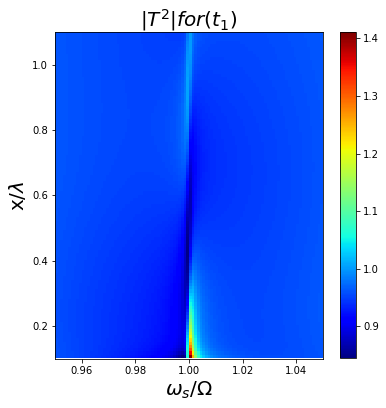

In [43]:
# 创建二维色图t
plt.figure(figsize=(6,6))
plt.imshow(abs(Transmission_o_x_t1)**2,cmap='jet', origin='lower', extent=[Omega_a/Omega, Omega_b/Omega, wavelength_a/wavelength, wavelength_b/wavelength], aspect='auto')
plt.colorbar()
plt.title('$|T^2|for(t_1)$',fontsize=20)
plt.xlabel('$\omega_s/\Omega$',fontsize=20)
plt.ylabel('x/$\lambda$',fontsize=20)
plt.show()

$ 
T(\omega_s,x,t)=T(\omega_s)e^{i\frac{\omega_s}{v_g}(x-v_gt)}$  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
$+\frac {iR(\omega_s)}{2\pi } e^ {i\frac {\Omega}{v_g}(x-v_gt)} e^ {\frac {\Gamma/2}{v_g}(x-v_gt)} [E_1(i\frac {x}{v_g}\tilde \Omega))+2\pi i - E_1(-i \frac {|x-v_gt|}{v_g}\tilde\Omega)]$  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
$+\frac{R(\omega_s)}{2\pi}$ $e^{i\frac {\omega_s}{v_g}(x-v_gt)}[ici(\omega_{s}\frac{x}{v_g})+si(\omega_s\frac{x}{v_g})-ici(\omega_s\frac{|x-v_ gt|}{v_g})+si(\omega_s\frac{|x-v_gt|}{v_g})]$

In [31]:
# directly compute with ci,si 
# t2
for i in range(x_width):
    for k in range(o_width):
        Transmission_omega_s = (omega_s[k]-Omega)/(omega_s[k]-Omega+1j*Gamma/2)
        Reflection_omega_s = -1j*Gamma/2/(omega_s[k]-Omega+1j*Gamma/2)
        EX = x[i]-velocity_g*t2
        E1a = 1j*x[i]/velocity_g*tilde_Omega
        E1b = -1j*abs(EX)/velocity_g*tilde_Omega
        si_a, ci_a = sc.sici(omega_s[k]*x[i]/velocity_g)
        si_a = si_a - math.pi/2
        si_b, ci_b = sc.sici(omega_s[k]*abs(x[i]-velocity_g*t2)/velocity_g)
        si_b = si_b - math.pi/2
        # Transmission_o_x_t2
        T1[i][k] = Transmission_omega_s*math.e**(1j*omega_s[k]/velocity_g*EX)
        T2[i][k] = 1j*Reflection_omega_s/(2*math.pi)*math.e**(1j*Omega/velocity_g*EX)*math.e**(Gamma/2/velocity_g*EX)*((sc.exp1(complex(np.real(E1a), np.imag(E1a)))) + 2*math.pi*1j - sc.exp1(complex(np.real(E1b), np.imag(E1b))))
        T3[i][k] = Reflection_omega_s/2/math.pi*math.e**(1j*omega_s[k]/velocity_g*EX)*(1j*ci_a+si_a-1j*ci_b+si_b)          
        Transmission_o_x_t2[i][k] = T1[i][k] + T2[i][k] + T3[i][k] 
        if x[i] <= 0 :
            print('x<=0')
            print('x=',x[i])
            print('i=',i,'k=',k)
            break
            break
        if EX >= 0 :
            print('x-velocity_g*t >= 0')
            break
            break
        

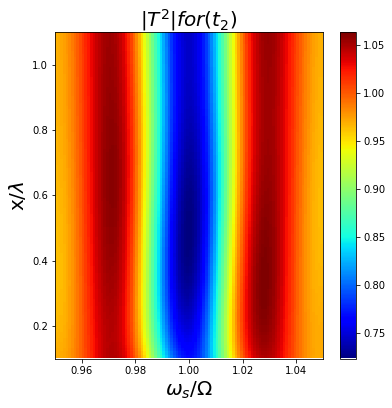

In [32]:
# 创建二维色图t
plt.figure(figsize=(6,6))
plt.imshow(abs(Transmission_o_x_t2)**2,cmap='jet', origin='lower', extent=[Omega_a/Omega, Omega_b/Omega, wavelength_a/wavelength, wavelength_b/wavelength], aspect='auto')
plt.colorbar()
plt.title('$|T^2|for(t_2)$',fontsize=20)
plt.xlabel('$\omega_s/\Omega$',fontsize=20)
plt.ylabel('x/$\lambda$',fontsize=20)
plt.show()